In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [5]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def load_data(self):
        self.df = pd.read_csv(self.file_path)
        # print("Loaded DataFrame:")
        # print(self.df.head())

    def feature_engineering(self):
        if self.df is None:
            self.load_data()
        columns_and_values = {
            'cap-shape': ['x', 'f'],
            'cap-surface': ['y', 's'],
            'cap-color': ['n', 'g', 'e', 'y', 'w'],
            'odor': ['n', 'f', 'y', 's'],
            'gill-color': ['b', 'p', 'w', 'n', 'g', 'h', 'u', 'k']
        }
        for column, valid_values in columns_and_values.items():
            self.df[column] = self.df[column].apply(lambda x: 'Others' if x not in valid_values else x)

    def preprocess_data(self):
        if self.df is None:
            self.load_data()
        X = pd.get_dummies(self.df.drop('class', axis=1))
        y = LabelEncoder().fit_transform(self.df['class'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # Split training set into training and validation
        # return X_train, X_val, X_test, y_train, y_val, y_test, X, y
        return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        # self.model = tf.keras.Sequential([
        #     layers.Input(shape=input_shape),
        #     layers.Dense(10, activation='relu'),
        #     layers.Dense(5, activation='relu'),
        #     layers.Dense(1, activation='sigmoid')
        # ])
        self.model = Sequential()
        self.model.add(Dense(units=10, activation='relu', input_shape=(input_shape,)))
        self.model.add(Dropout(rate=0.3))
        self.model.add(Dense(units=5, activation='relu'))
        self.model.add(Dropout(rate=0.3))
        self.model.add(Dense(units=1, activation='sigmoid'))

        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int).flatten()
        if isinstance(y_test, pd.Series):
           y_test = y_test.values
        y_true = y_test.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1


In [7]:
# Example usage:
file_path = 'mushrooms.csv'
data_processor = DataPreprocessor(file_path)
data_processor.feature_engineering()
# X_train, X_val, X_test, y_train, y_val, y_test, Xc, yc = data_processor.preprocess_data()
X_train, X_val, X_test, y_train, y_val, y_test = data_processor.preprocess_data()

In [8]:
# # Define reduction percentages
# reduction_percentage = 0.7

# # Reduce the size of the datasets
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
# X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [9]:
X_train.shape , X_val.shape, X_test.shape,  y_train.shape

((4874, 102), (1625, 102), (1625, 102), (4874,))

In [10]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
153/153 [==============================] - 4s 9ms/step - loss: 0.6969 - accuracy: 0.4953 - val_loss: 0.6852 - val_accuracy: 0.6246 - lr: 0.0100
Epoch 2/50
153/153 [==============================] - 1s 8ms/step - loss: 0.6746 - accuracy: 0.5862 - val_loss: 0.6521 - val_accuracy: 0.8043 - lr: 0.0100
Epoch 3/50
153/153 [==============================] - 1s 8ms/step - loss: 0.6344 - accuracy: 0.6428 - val_loss: 0.5925 - val_accuracy: 0.8886 - lr: 0.0100
Epoch 4/50
153/153 [==============================] - 1s 8ms/step - loss: 0.5843 - accuracy: 0.6949 - val_loss: 0.5132 - val_accuracy: 0.9052 - lr: 0.0100
Epoch 5/50
153/153 [==============================] - 1s 7ms/step - loss: 0.5258 - accuracy: 0.7275 - val_loss: 0.4105 - val_accuracy: 0.9046 - lr: 0.0100
Epoch 6/50
153/153 [==============================] - 1s 6ms/step - loss: 0.4680 - accuracy: 0.7604 - val_loss: 0.3337 - val_accuracy: 0.9120 - lr: 0.0100
Epoch 7/50
153/153 [=============

In [11]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.9926, Precision - 0.9927, Recall - 0.9926, F1-score - 0.9926, Convergence Speed - 50 epochs, Training Time - 49.27 seconds
SGD_momentum: Test Accuracy - 1.0000, Precision - 1.0000, Recall - 1.0000, F1-score - 1.0000, Convergence Speed - 50 epochs, Training Time - 42.49 seconds
Nesterov: Test Accuracy - 1.0000, Precision - 1.0000, Recall - 1.0000, F1-score - 1.0000, Convergence Speed - 50 epochs, Training Time - 36.34 seconds
RMSprop: Test Accuracy - 1.0000, Precision - 1.0000, Recall - 1.0000, F1-score - 1.0000, Convergence Speed - 50 epochs, Training Time - 40.92 seconds
Adagrad: Test Accuracy - 0.9138, Precision - 0.9163, Recall - 0.9138, F1-score - 0.9136, Convergence Speed - 50 epochs, Training Time - 34.40 seconds
Adadelta: Test Accuracy - 0.4837, Precision - 0.3178, Recall - 0.4837, F1-score - 0.3470, Convergence Speed - 50 epochs, Training Time - 35.20 seconds
Adam: Test Accuracy - 1.0000, Precision - 1.0000, Recall - 1.0000, F1-score - 1.0000, C

In [12]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Mushroom"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["FNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Mushroom,4874,102,int32,FNN,SGD,0.992615,0.992719,0.992615,0.992613,50,49.272103,0.696928,0.685176
1,Mushroom,4874,102,int32,FNN,SGD_momentum,1.000000,1.000000,1.000000,1.000000,50,42.486303,0.451993,0.132763
2,Mushroom,4874,102,int32,FNN,Nesterov,1.000000,1.000000,1.000000,1.000000,50,36.344194,0.533024,0.177616
3,Mushroom,4874,102,int32,FNN,RMSprop,1.000000,1.000000,1.000000,1.000000,50,40.918924,0.514212,0.259998
4,Mushroom,4874,102,int32,FNN,Adagrad,0.913846,0.916349,0.913846,0.913571,50,34.403564,0.721530,0.676286
5,Mushroom,4874,102,int32,FNN,Adadelta,0.483692,0.317802,0.483692,0.346993,50,35.203112,0.772025,0.748139
6,Mushroom,4874,102,int32,FNN,Adam,1.000000,1.000000,1.000000,1.000000,40,29.558885,0.513128,0.270003
7,Mushroom,4874,102,int32,FNN,AMSGrad,1.000000,1.000000,1.000000,1.000000,50,41.241745,0.506749,0.234574
8,Mushroom,4874,102,int32,FNN,AdamW,1.000000,1.000000,1.000000,1.000000,50,44.436221,0.567448,0.392130
9,Mushroom,4874,102,int32,FNN,Yogi,1.000000,1.000000,1.000000,1.000000,33,44.079992,0.241282,0.030389


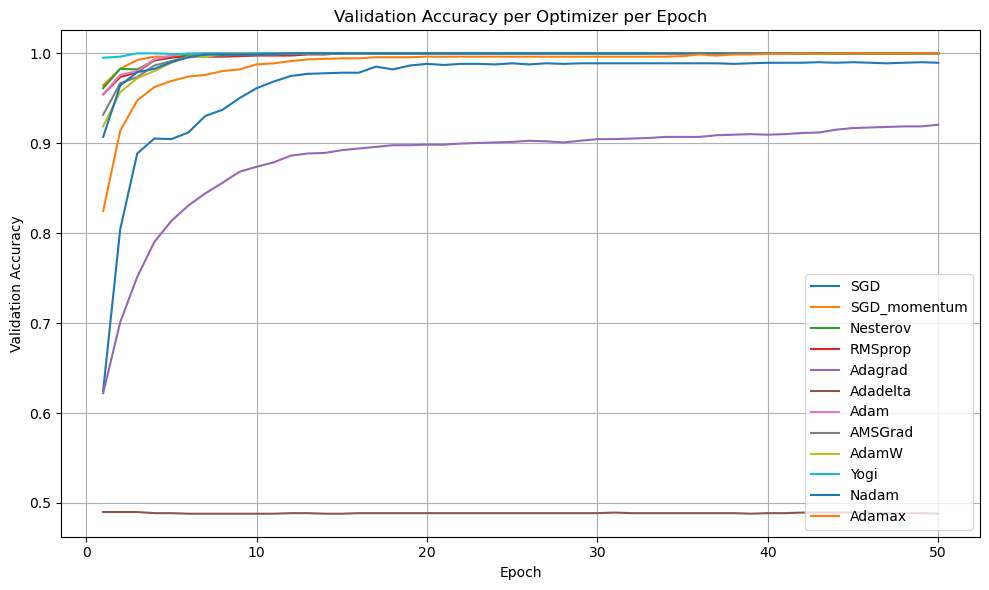

In [13]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


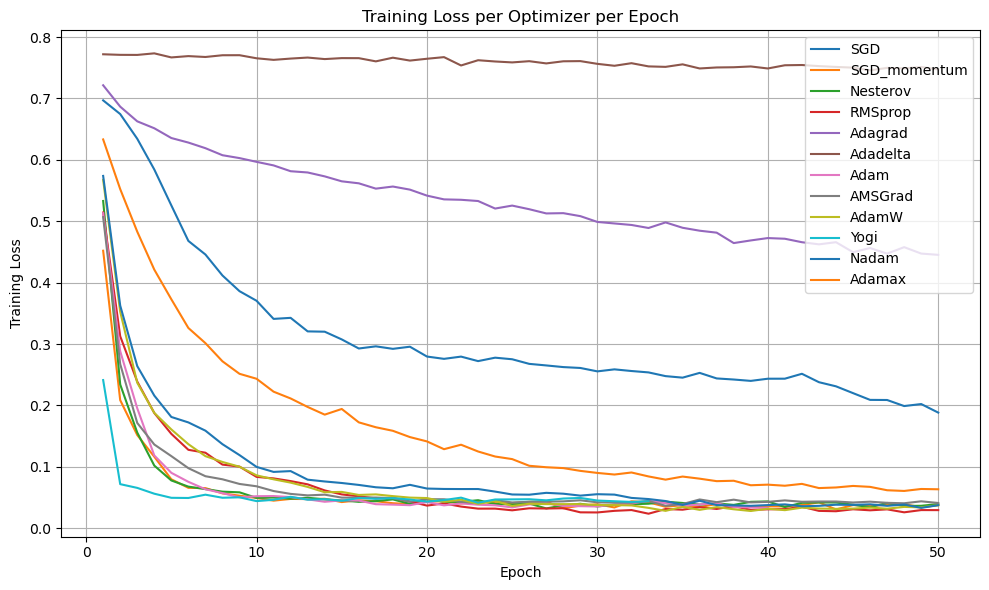

In [14]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
final_df.to_csv('Mushroom Classification_nn_r(3).csv', index=False)

In [1]:
################################## Before Presentation ###########################################

In [15]:
!pip install tensorflow-addons

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import time
import tensorflow_addons as tfa

In [17]:
class DataPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def load_data(self):
        self.df = pd.read_csv(self.file_path)
        print("Loaded DataFrame:")
        print(self.df.head())

    def feature_engineering(self):
        if self.df is None:
            self.load_data()
        columns_and_values = {
            'cap-shape': ['x', 'f'],
            'cap-surface': ['y', 's'],
            'cap-color': ['n', 'g', 'e', 'y', 'w'],
            'odor': ['n', 'f', 'y', 's'],
            'gill-color': ['b', 'p', 'w', 'n', 'g', 'h', 'u', 'k']
        }
        for column, valid_values in columns_and_values.items():
            self.df[column] = self.df[column].apply(lambda x: 'Others' if x not in valid_values else x)

    def preprocess_data(self):
        if self.df is None:
            self.load_data()
        X = pd.get_dummies(self.df.drop('class', axis=1))
        y = LabelEncoder().fit_transform(self.df['class'])
        return train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_shape, optimizer='adam'):
        self.model = tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Dense(10, activation='relu'),
            layers.Dense(5, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, epochs=2, batch_size=32, validation_data=None):
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)


In [19]:
# Example usage:
file_path = 'mushrooms.csv'
data_preprocessor = DataPreprocessor(file_path)
data_preprocessor.feature_engineering()
X_train, X_test, y_train, y_test = data_preprocessor.preprocess_data()

Loaded DataFrame:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p     

In [ ]:
import matplotlib.pyplot as plt

# List of optimizers to test for NN
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9),
    'Nesterov': tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': tf.keras.optimizers.Adam(),
    'AMSGrad': tf.keras.optimizers.Adam(amsgrad=True),
    'AdamW': tfa.optimizers.AdamW(weight_decay=1e-4),
    'Yogi': tfa.optimizers.Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

for name, optimizer_name in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(X_train.shape[1], optimizer=optimizer_name)
    start_time = time.time()
    history = model_instance.train(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(X_test, y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}


# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

Training model with SGD optimizer...
51/51 [==============================] - 0s 3ms/step - loss: 0.3369 - accuracy: 0.9175
Training model with SGD_momentum optimizer...
51/51 [==============================] - 0s 3ms/step - loss: 0.0512 - accuracy: 0.9803
Training model with Nesterov optimizer...
51/51 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9957
Training model with RMSprop optimizer...
51/51 [==============================] - 0s 3ms/step - loss: 0.1352 - accuracy: 0.9723
Training model with Adagrad optimizer...
199/204 [============================>.] - ETA: 0s - loss: 0.7420 - accuracy: 0.4488

In [9]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Yogi
Accuracy: 0.9994
Loss: 0.1263
Shortest Training Time: 3.57 seconds


Comparison of Optimizers:
              accuracy      loss  training_time
SGD           0.896615  0.576780       3.833255
SGD_momentum  0.991385  0.193867       2.518000
Nesterov      0.987077  0.219818       1.785757
RMSprop       0.968000  0.287226       2.480500
Adagrad       0.528000  0.587325       1.982108
Adadelta      0.532308  0.683332       1.960166
Adam          0.966154  0.273866       1.991687
AMSGrad       0.980923  0.317284       2.080656
AdamW         0.956923  0.469110       2.171278
Yogi          0.999385  0.126335       3.567085
Nadam         0.962462  0.401579       3.259513
Adamax        0.849846  0.586068       2.024014


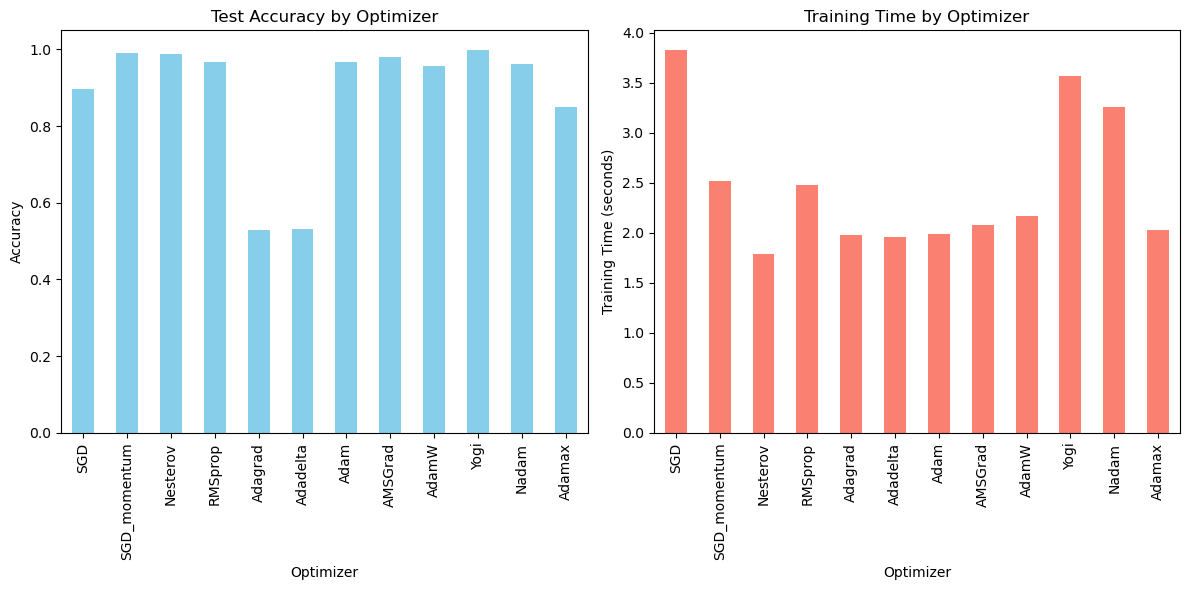

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


In [20]:
import tensorflow as tf
import tensorflow_addons as tfa
import time
import pandas as pd
import matplotlib.pyplot as plt

class OptimizerEvaluator:
    def __init__(self, model_builder, X_train, y_train, X_test, y_test):
        self.model_builder = model_builder  # This will build and return a new model instance
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.results = {}

        self.optimizers = {
            'SGD': tf.keras.optimizers.SGD(),
            'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9),
            'Nesterov': tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
            'RMSprop': tf.keras.optimizers.RMSprop(),
            'Adagrad': tf.keras.optimizers.Adagrad(),
            'Adadelta': tf.keras.optimizers.Adadelta(),
            'Adam': tf.keras.optimizers.Adam(),
            'AMSGrad': tf.keras.optimizers.Adam(amsgrad=True),
            'AdamW': tfa.optimizers.AdamW(weight_decay=1e-4),
            'Yogi': tfa.optimizers.Yogi(),
            'Nadam': tf.keras.optimizers.Nadam(),
            'Adamax': tf.keras.optimizers.Adamax()
        }

    def evaluate_optimizers(self):
        for name, optimizer in self.optimizers.items():
            print(f"Training model with {name} optimizer...")
            model_instance = NeuralNetworkModel()
            model_instance.build_ann(X_train.shape[1], optimizer=optimizer)
            start_time = time.time()
            history = model_instance.train(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
            end_time = time.time()
            test_loss, test_acc = model_instance.evaluate(X_test, y_test)
            training_time = end_time - start_time

            self.results[name] = {
                'test_accuracy': test_acc,
                'convergence_speed': len(history.history['loss']),
                'training_time': training_time,
                'history': history
            }

    def determine_best_optimizer(self):
        best_optimizer = None
        best_accuracy = 0
        lowest_loss = float('inf')
        shortest_training_time = float('inf')

        for optimizer, metrics in self.results.items():
            accuracy = metrics['test_accuracy']
            loss = metrics['history'].history['loss'][-1]
            training_time = metrics['training_time']

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                lowest_loss = loss
                shortest_training_time = training_time
                best_optimizer = optimizer
            elif accuracy == best_accuracy and loss < lowest_loss:
                lowest_loss = loss
                shortest_training_time = training_time
                best_optimizer = optimizer
            elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
                shortest_training_time = training_time
                best_optimizer = optimizer

        return {
            'best_optimizer': best_optimizer,
            'accuracy': best_accuracy,
            'loss': lowest_loss,
            'training_time': shortest_training_time
        }

   
    def display_results(self):
        # Create a dataframe for comparison
        df = pd.DataFrame.from_dict({
            optimizer: {
                'accuracy': result['test_accuracy'],
                'loss': result['history'].history['loss'][-1],
                'training_time': result['training_time']
            } for optimizer, result in self.results.items()
        }, orient='index')
    
        # Print comparison table
        print("Comparison of Optimizers:")
        print(df)
    
        # Plot the comparison using graphs
        plt.figure(figsize=(18, 6))  # Adjusted the figure size to accommodate three subplots
    
        # Plot accuracy comparison
        plt.subplot(1, 3, 1)
        df['accuracy'].plot(kind='bar', color='skyblue')
        plt.title('Test Accuracy by Optimizer')
        plt.xlabel('Optimizer')
        plt.ylabel('Accuracy')
    
        # Plot training time comparison
        plt.subplot(1, 3, 2)
        df['training_time'].plot(kind='bar', color='salmon')
        plt.title('Training Time by Optimizer')
        plt.xlabel('Optimizer')
        plt.ylabel('Training Time (seconds)')
    
        # Plot loss comparison
        plt.subplot(1, 3, 3)
        for name, result in self.results.items():
            plt.plot(result['history'].history['loss'], label=name)
        plt.title('Training Loss by Optimizer')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.tight_layout()  # Ensure layout doesn't overlap
        plt.show()

   

Training model with SGD optimizer...
Epoch 1/100
204/204 [==============================] - 2s 9ms/step - loss: 0.5569 - accuracy: 0.7229 - val_loss: 0.4647 - val_accuracy: 0.8628
Epoch 2/100
204/204 [==============================] - 1s 7ms/step - loss: 0.4020 - accuracy: 0.9000 - val_loss: 0.3556 - val_accuracy: 0.9194
Epoch 3/100
204/204 [==============================] - 1s 7ms/step - loss: 0.3089 - accuracy: 0.9323 - val_loss: 0.2735 - val_accuracy: 0.9428
Epoch 4/100
204/204 [==============================] - 1s 7ms/step - loss: 0.2260 - accuracy: 0.9508 - val_loss: 0.1910 - val_accuracy: 0.9569
Epoch 5/100
204/204 [==============================] - 1s 7ms/step - loss: 0.1552 - accuracy: 0.9658 - val_loss: 0.1355 - val_accuracy: 0.9717
Epoch 6/100
204/204 [==============================] - 1s 7ms/step - loss: 0.1111 - accuracy: 0.9758 - val_loss: 0.0998 - val_accuracy: 0.9760
Epoch 7/100
204/204 [==============================] - 1s 7ms/step - loss: 0.0858 - accuracy: 0.9797 - va

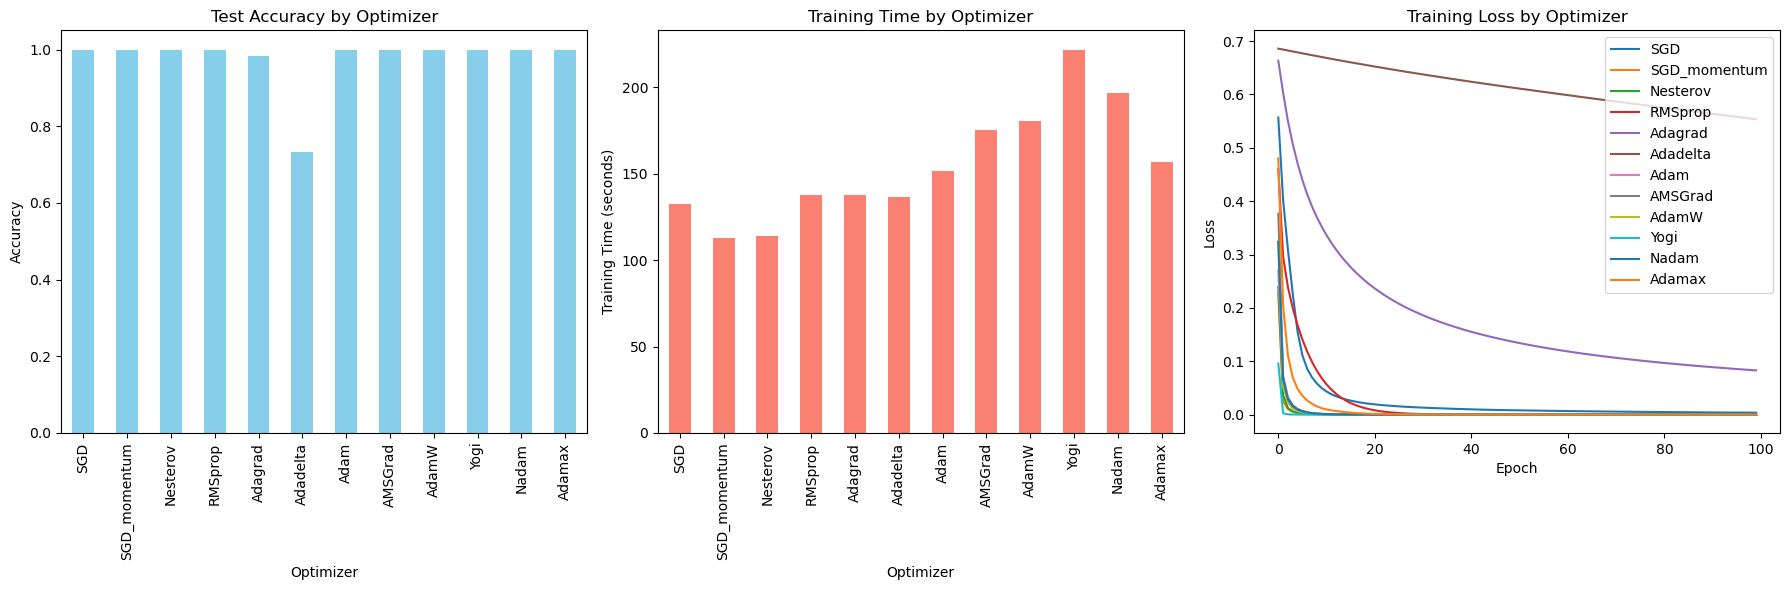

Best performing optimizer: Adamax
Accuracy: 1.0
Loss: 9.358841479567559e-10
Training Time: 157.0397391319275 seconds


In [21]:
# Instantiate the model
model_builder = NeuralNetworkModel()

evaluator = OptimizerEvaluator(model_builder, X_train, y_train, X_test, y_test)
evaluator.evaluate_optimizers()  # Train models using different optimizers
best_optimizer = evaluator.determine_best_optimizer()  # Find the best optimizer
evaluator.display_results()  # Print results and plot comparisons

print("Best performing optimizer:", best_optimizer['best_optimizer'])
print("Accuracy:", best_optimizer['accuracy'])
print("Loss:", best_optimizer['loss'])
print("Training Time:", best_optimizer['training_time'], "seconds")

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow.keras import layers
# import time

# class DataPreprocessor:
#     def __init__(self, file_path):
#         self.file_path = file_path
#         self.df = None
#         self.X_train = None
#         self.X_test = None
#         self.y_train = None
#         self.y_test = None

#     def load_data(self):
#         self.df = pd.read_csv(self.file_path)
#         print("Loaded DataFrame:")
#         print(self.df.head())  # Print the DataFrame to check if it's loaded correctly

#     def feature_engineering(self):
#         if self.df is None:
#             self.load_data()
#         self._apply_others('cap-shape', ['x', 'f'])
#         self._apply_others('cap-surface', ['y', 's'])
#         self._apply_others('cap-color', ['n', 'g', 'e', 'y', 'w'])
#         self._apply_others('odor', ['n', 'f', 'y', 's'])
#         self._apply_others('gill-color', ['b', 'p', 'w', 'n', 'g', 'h', 'u', 'k'])

#     def _apply_others(self, column, valid_values):
#         def others(value):
#             if value not in valid_values:
#                 return 'Others'
#             else:
#                 return value
#         self.df[column] = self.df[column].apply(others)

#     def preprocess_data(self):
#         if self.df is None:
#             self.load_data()
#         X = self.df.drop('class', axis=1)
#         y = self.df['class']
#         X = pd.get_dummies(X)

#         label_encoder = LabelEncoder()
#         y = label_encoder.fit_transform(y)

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#         self.X_train = X_train
#         self.X_test = X_test
#         self.y_train = y_train
#         self.y_test = y_test

#         return self.X_train, self.X_test, self.y_train, self.y_test


In [ ]:
# class NeuralNetworkModel:
#     def __init__(self):
#         self.model = None
#         self.history = None

#     def build_ann(self, input_shape, optimizer='adam'):
#         self.model = tf.keras.Sequential([
#             layers.Input(shape=input_shape),
#             layers.Dense(10, activation='relu'),
#             layers.Dense(5, activation='relu'),
#             layers.Dense(1, activation='sigmoid')
#         ])
#         self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#     def train(self, X_train, y_train, epochs=2, batch_size=32, validation_data=None):
#         self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
#         return self.history

#     def evaluate(self, X_test, y_test):
#         return self.model.evaluate(X_test, y_test)


In [ ]:
# # Example usage:
# file_path = 'mushrooms.csv'
# data_preprocessor = DataPreprocessor(file_path)
# data_preprocessor.feature_engineering()
# X_train, X_test, y_train, y_test = data_preprocessor.preprocess_data()


In [ ]:

# # List of optimizers to test for NN
# optimizers = {
#     'SGD': 'SGD',
#     'Adam': 'adam',
#     'RMSprop': 'RMSprop',
#     'Adagrad': 'Adagrad',
#     'Adadelta': 'Adadelta',
#     'Adamax': 'Adamax',
#     'Nadam': 'Nadam'
# }


# results = {}

# for name, optimizer_name in optimizers.items():
#     print(f"Training model with {name} optimizer...")
#     model_instance = NeuralNetworkModel()
#     model_instance.build_ann(X_train.shape[1], optimizer=optimizer_name)
#     start_time = time.time()
#     history = model_instance.train(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))
#     end_time = time.time()
#     test_loss, test_acc = model_instance.evaluate(X_test, y_test)
#     training_time = end_time - start_time
#     results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# # Print results
# print("\nResults:")
# for name, result in results.items():
#     print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
#           f"Convergence Speed - {result['convergence_speed']} epochs, "
#           f"Training Time - {result['training_time']:.2f} seconds")

# # Plot training history
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# for name, result in results.items():
#     plt.plot(result['history'].history['loss'], label=name)
# plt.title('Training Loss by Optimizer')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# for name, result in results.items():
#     plt.plot(result['history'].history['accuracy'], label=name)
# plt.title('Test Accuracy by Optimizer')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# for name, result in results.items():
#     plt.bar(name, result['training_time'])
# plt.title('Training Time by Optimizer')
# plt.xlabel('Optimizer')
# plt.ylabel('Training Time (seconds)')
# plt.show()

In [ ]:
# # Step 1: Collect results and metrics
# optimizer_metrics = {}  # Dictionary to store optimizer metrics

# for optimizer, result in results.items():
#     accuracy = result['test_accuracy']
#     loss = result['history'].history['loss'][-1]
#     training_time = result['training_time']
#     optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# # Step 2: Analyze metrics
# best_optimizer = None
# best_accuracy = 0
# lowest_loss = float('inf')
# shortest_training_time = float('inf')

# for optimizer, metrics in optimizer_metrics.items():
#     accuracy = metrics['accuracy']
#     loss = metrics['loss']
#     training_time = metrics['training_time']
    
#     # Determine the best optimizer based on accuracy, loss, and training time
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         lowest_loss = loss
#         shortest_training_time = training_time
#         best_optimizer = optimizer
#     elif accuracy == best_accuracy and loss < lowest_loss:
#         lowest_loss = loss
#         shortest_training_time = training_time
#         best_optimizer = optimizer
#     elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
#         shortest_training_time = training_time
#         best_optimizer = optimizer

# # Step 3: Print or return the best performing optimizer
# print(f"Best performing optimizer: {best_optimizer}")
# print(f"Accuracy: {best_accuracy:.4f}")
# print(f"Loss: {lowest_loss:.4f}")
# print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

In [11]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Step 1: Collect results and metrics
# optimizer_metrics = {}  # Dictionary to store optimizer metrics

# for optimizer, result in results.items():
#     accuracy = result['test_accuracy']
#     loss = result['history'].history['loss'][-1]
#     training_time = result['training_time']
#     optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# # Step 2: Create a dataframe for comparison
# df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# # Step 3: Plot the comparison using a table
# print("Comparison of Optimizers:")
# print(df)

# # Step 4: Plot the comparison using a graph
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# df['accuracy'].plot(kind='bar', color='skyblue')
# plt.title('Test Accuracy by Optimizer')
# plt.xlabel('Optimizer')
# plt.ylabel('Accuracy')

# plt.subplot(1, 2, 2)
# df['training_time'].plot(kind='bar', color='salmon')
# plt.title('Training Time by Optimizer')
# plt.xlabel('Optimizer')
# plt.ylabel('Training Time (seconds)')

# plt.tight_layout()
# plt.show()
